<a href="https://colab.research.google.com/github/i-m-alamin/Speech_Emotion_Analysis_using__MLPClassifier_-_LSTM_On_SUBESCO_Dataset/blob/main/Speech_Emotion_Analysis_using__MLPClassifier_%26_LSTM_On_SUBESCO_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display 
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [ ]:
labels =[]
paths = []
for dirname, _, filenames in os.walk('SUBESCO/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-2] + filename.split('_')[-1] 
        label = filename.split('_')[-2]
        labels.append(label.lower())
print('dataset loading complete') 

dataset loading complete


In [ ]:
labels[0:5]

[]

In [ ]:
#creating a data frame
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label


In [ ]:
df['label'].value_counts()

Series([], Name: label, dtype: int64)

## Data Analysis

<AxesSubplot:xlabel='label', ylabel='count'>

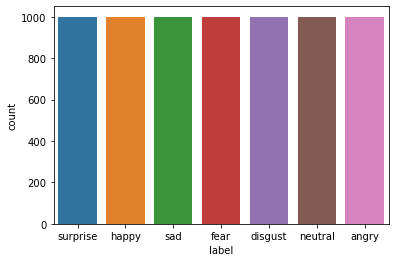

In [ ]:
#If all are same , no need to class balancing
sns.countplot(df['label']) 

In [ ]:
#display waveform & spectogram
def waveplot(data, srate, emotion):
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=srate)
    plt.show()
    
def spectogram(data, srate, emotion):
    x= librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(12,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=srate, x_axis='time', y_axis='hz')
    plt.colorbar()

In [ ]:
emotion='happy'
path=np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate =librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)

Audio(path)

IndexError: ignored

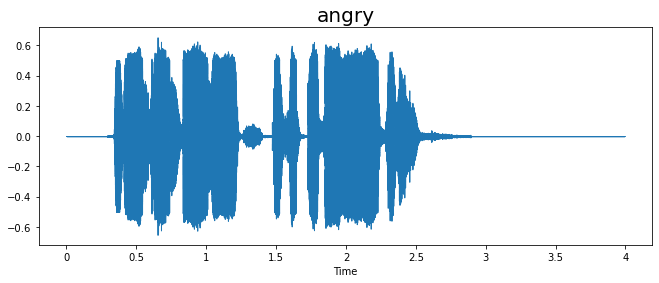

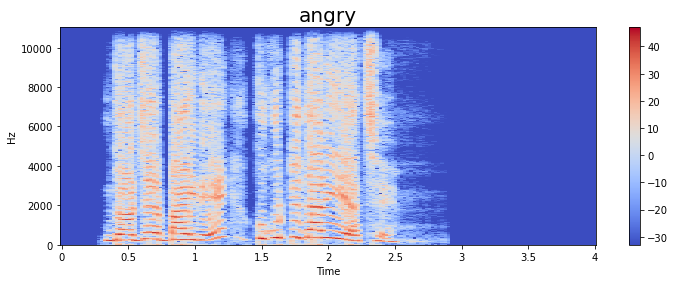

In [ ]:
emotion='angry'
path=np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate =librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)

Audio(path)

In [ ]:
def noise(data):
    noiseAmp= 0.035 *np.random.uniform()*np.amax(data)
    data = data + noiseAmp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shiftRange= int(np.random.uniform(low=5, high=5)*1000)
    return np.roll(data, shiftRange)

def pitch(data, srate, pitchFactor=0.7):
    return librosa.effects.pitch_shift(data, srate, pitchFactor)


<Figure size 1008x288 with 0 Axes>

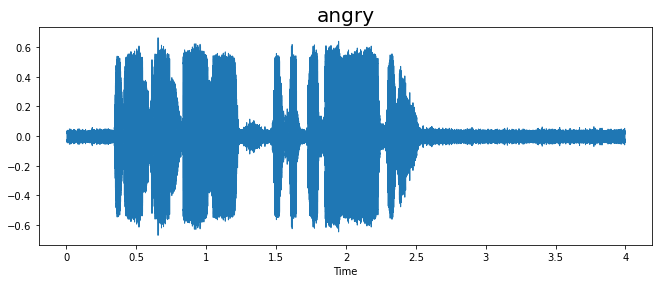

In [ ]:
emotion='angry'
path=np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate =librosa.load(path)
x=noise(data)
plt.figure(figsize=(14,4))
waveplot(x, sampling_rate, emotion)
Audio(x, rate=sampling_rate)


<Figure size 1008x288 with 0 Axes>

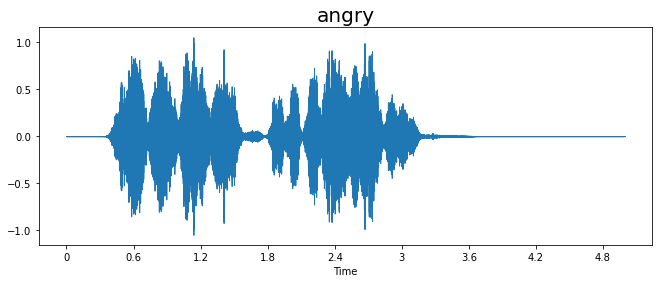

In [ ]:
x=stretch(data)
plt.figure(figsize=(14,4))
waveplot(x, sampling_rate, emotion)
Audio(x, rate=sampling_rate)

<Figure size 1008x288 with 0 Axes>

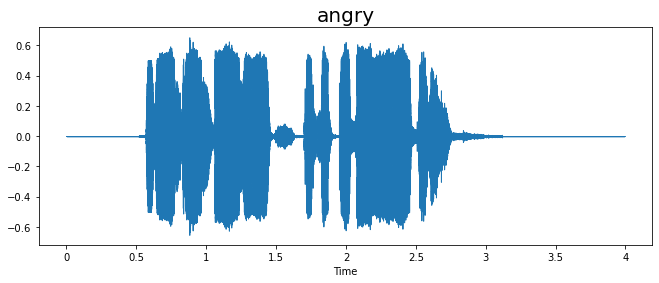

In [ ]:
x=shift(data)
plt.figure(figsize=(14,4))
waveplot(x, sampling_rate, emotion)
Audio(x, rate=sampling_rate)

<Figure size 1008x288 with 0 Axes>

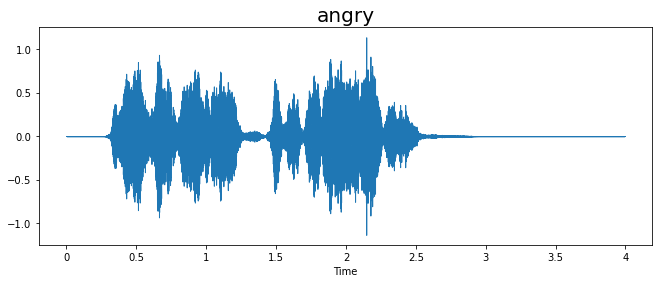

In [ ]:
x=pitch(data, sampling_rate, pitchFactor=0.7)
plt.figure(figsize=(14,4))
waveplot(x, sampling_rate, emotion)
Audio(x, rate=sampling_rate)

 ## Feature Extraction

In [ ]:
#feature extraction using MFCC-
def feature_extraction(filename, mfcc, chroma, mel):
    d, srate = librosa.load(filename, duration=5, offset=0.5)
    if chroma:
        stft = np.abs(librosa.stft(d))
        stft= librosa.amplitude_to_db(stft)
    result = np.array([])
    if mfcc:
        mfccr = np.mean(librosa.feature.mfcc(d, sr=srate, n_mfcc=23).T, axis=0)
        result = np.hstack((result, mfccr))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=srate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel= np.mean(librosa.feature.melspectrogram(d, sr=srate, n_mels=40).T, axis=0)
        mel = librosa.power_to_db(mel)
        result = np.hstack((result, mel))
    return result

In [ ]:
p=[feature_extraction(df['speech'][100], mfcc=True, chroma=True, mel=True)]
np.array(p).shape

NameError: ignored

In [ ]:
X_features= df['speech'].apply(lambda x: feature_extraction(x, mfcc=True, chroma=True, mel=True))

In [ ]:
#X-mfcc is in dataframe structure.. convert it into 2D array
X=[x for x in X_features]
np.array(X).shape

NameError: ignored

In [ ]:
# for LSTM model we have to expand 1 dimension
#X = np.expand_dims(X, -1)
#X.shape

(7000, 40, 1)

In [ ]:
#label_map = {label: num for num, label in enumerate(df['label'])}
emotions=['angry' , 'surprise', 'neutral', 'disgust', 'sad', 'fear', 'happy']
label_map = {label: num for num, label in enumerate(emotions)}
label_map

{'angry': 0,
 'surprise': 1,
 'neutral': 2,
 'disgust': 3,
 'sad': 4,
 'fear': 5,
 'happy': 6}

In [ ]:
# using to_categorical to change the format of the label according to label_map
#from tensorflow.keras.utils import to_categorical
#df2=df.replace({'label' : label_map})
#df2.head()
#y=df2['label'].to_numpy()
#print(to_categorical(y))

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [ ]:
#one hot encoding of labels
#from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder()
#enc_df = pd.DataFrame(enc.fit_transform(df[['label']]).toarray())
#y=enc_df.to_numpy()
#y

In [ ]:
# y for mlpclassifier
y_mlp= df['label'].to_numpy()
print(y_mlp)

['surprise' 'happy' 'happy' ... 'sad' 'sad' 'fear']


In [ ]:
#train set and test set for mlp classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y_mlp, test_size=0.15, random_state=0) # convert X to array 

In [ ]:
print(y_train.shape[0], y_test.shape[0])

5950 1050


In [ ]:
# features Extracted 
print(f'features Extracted: {X_train.shape[1]}')

features Extracted: 75


## MLPClassifier Model 

In [ ]:
# Determine Best Parameters for MLPClassifier.
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
estimator = MLPClassifier(learning_rate='adaptive', max_iter=1000)

# Set parameters to search

parameters = {
    'hidden_layer_sizes': [(100,), (150, 100), (200, 150, 100)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam']
    }
    
# Perform grid search
gridsearch = GridSearchCV(estimator, parameters, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", refit=True)

gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 44.8min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 116.5min finished


GridSearchCV(estimator=MLPClassifier(learning_rate='adaptive', max_iter=1000),
             n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(100,), (150, 100),
                                                (200, 150, 100)],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='accuracy', verbose=1)

/home/sherlock/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/sherlock/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/sherlock/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum

/home/sherlock/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/sherlock/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/sherlock/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum

In [ ]:
print(f'Best estimator: {gridsearch.best_estimator_}')
print(f'Best parameters: {gridsearch.best_params_}')

Best estimator: MLPClassifier(activation='logistic', hidden_layer_sizes=(150, 100),
              learning_rate='adaptive', max_iter=1000)
Best parameters: {'activation': 'logistic', 'hidden_layer_sizes': (150, 100), 'solver': 'adam'}


In [ ]:
# Disigning the network according the best parameters results
model4= MLPClassifier(alpha=0.01, activation='logistic', batch_size=256, hidden_layer_sizes=(150,100), learning_rate='adaptive', max_iter=1000)
model4.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.01, batch_size=256,
              hidden_layer_sizes=(150, 100), learning_rate='adaptive',
              max_iter=1000)

## Result Analysis 

In [ ]:
#prediction on the model and different analysis parameter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred = model4.predict(X_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_test, y_pred))

Accuracy: 85.62%
[[123  20   1   5   0   1   2]
 [  5 113   1   7   0   3   8]
 [  0   1 143   1   0   3  12]
 [  0  15   0 120   3   5   6]
 [  2   1   3   0 128   1   2]
 [  1   1   7   5  15 146   2]
 [  0   8   1   1   0   2 126]]
              precision    recall  f1-score   support

       angry       0.81      0.94      0.87       131
     disgust       0.82      0.71      0.76       159
        fear       0.89      0.92      0.91       156
       happy       0.81      0.86      0.83       139
     neutral       0.93      0.88      0.90       146
         sad       0.82      0.91      0.86       161
    surprise       0.91      0.80      0.85       158

    accuracy                           0.86      1050
   macro avg       0.86      0.86      0.86      1050
weighted avg       0.86      0.86      0.86      1050



In [ ]:
import pandas as pd
pred_df= pd.DataFrame({'Actual' : y_test, 'Predicted' : y_pred})
pred_df[:20]

,Actual,Predicted
0,disgust,angry
1,fear,fear
2,neutral,neutral
3,fear,fear
4,surprise,disgust
5,neutral,neutral
6,angry,angry
7,disgust,angry
8,neutral,neutral
9,happy,happy


In [ ]:
# save the model to disk
import pickle
filename = 'MultiLayer_perceptron_model.sav'
pickle.dump(model4, open(filename, 'wb'))

NameError: name 'model4' is not defined

In [ ]:
#Load the model and test

import pickle
filename='MultiLayer_perceptron_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
feature = feature_extraction('Realtime_Input_Dataset/Angry/angry_nafia.wav', mfcc=True, chroma=True, mel=True)

# convert the 1D array into 2D array
feature=feature.reshape(1,-1)
print(feature.shape)
prediction=loaded_model.predict(np.array(feature))
prediction

(1, 75)


array(['sad'], dtype='<U8')

## Creating a LSTM Network Model

In [ ]:
# for LSTM model we have to expand 1 dimension
X_lstm = np.expand_dims(X, -1)
type(np.array(X_lstm))

numpy.ndarray

In [ ]:
# using to_categorical to change the format of the label according to label_map
from tensorflow.keras.utils import to_categorical
df2=df.replace({'label' : label_map}) #replacing the labels with digit (angry:00)
df2.head()
y=df2['label'].to_numpy()
y_lstm = to_categorical(y)
print(y_lstm[0])

[0. 1. 0. 0. 0. 0. 0.]


In [ ]:
#train set and test set for LSTM Model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.15) # convert X to array 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(180, return_sequences=True, recurrent_dropout=0.2), input_shape=(180,1))) #X.shape[1:2]
model.add(Bidirectional(LSTM(180, return_sequences=False, recurrent_dropout=0.2)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_lstm.shape[1], activation='softmax')) # final output 7 emotions. y_lstm.shape=7000 * 7

## Compiling the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 180, 360)         262080    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 360)              779040    
 nal)                                                            
                                                                 
 dense_23 (Dense)            (None, 32)                11552     
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 7)                 231       
                                                                 
Total params: 1,052,903
Trainable params: 1,052,903
No

In [ ]:
# EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
## Training the Model
history= model.fit(X_train, y_train, epochs=15, batch_size= 256, 
                   shuffle=True)

Epoch 1/15
24/24 [==============================] - 463s 19s/step - loss: 1.7539 - accuracy: 0.2788
Epoch 2/15
24/24 [==============================] - 441s 18s/step - loss: 1.5847 - accuracy: 0.3617
Epoch 3/15
24/24 [==============================] - 416s 17s/step - loss: 1.5225 - accuracy: 0.3877
Epoch 4/15
24/24 [==============================] - 419s 17s/step - loss: 1.4456 - accuracy: 0.4160
Epoch 5/15
24/24 [==============================] - 435s 18s/step - loss: 1.3959 - accuracy: 0.4492
Epoch 6/15
24/24 [==============================] - 448s 19s/step - loss: 1.3234 - accuracy: 0.4738
Epoch 7/15
24/24 [==============================] - 454s 19s/step - loss: 1.2754 - accuracy: 0.4929
Epoch 8/15
24/24 [==============================] - 484s 20s/step - loss: 1.2441 - accuracy: 0.5059
Epoch 9/15
24/24 [==============================] - 435s 18s/step - loss: 1.1774 - accuracy: 0.5334
Epoch 10/15
24/24 [==============================] - 448s 19s/step - loss: 1.1552 - accuracy: 0.5459

In [ ]:
model.save('Bengali_audio_emotion_classifier.h5')

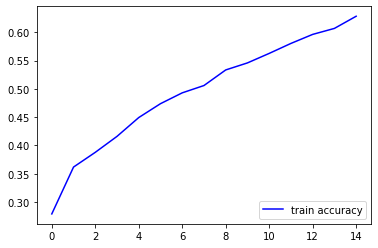

In [ ]:
plt.plot(history.history['accuracy'],c='b',label='train accuracy')
#plt.plot(history.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
y_pred =   np.argmax(model.predict(X_test), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.79      0.66      0.72       193
           1       0.47      0.57      0.51       120
           2       0.83      0.67      0.74       183
           3       0.26      0.56      0.36        72
           4       0.56      0.54      0.55       148
           5       0.86      0.66      0.74       198
           6       0.60      0.67      0.63       136

    accuracy                           0.63      1050
   macro avg       0.63      0.62      0.61      1050
weighted avg       0.68      0.63      0.64      1050



In [ ]:
X_lstm.shape

(7000, 75, 1)

In [ ]:
#  train set and test set for LSTM Model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.15, random_state=0) # convert X to array 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional

In [ ]:
model2 = Sequential()

model2.add(LSTM(128, return_sequences=True, input_shape=(25,1))) #X.shape[1:2]
model2.add(LSTM(64))

model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(y_lstm.shape[1], activation='softmax')) # final output 7 emotions. y_lstm.shape=7000 * 7

## Compiling the model
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 25, 128)           66560     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 7)                 231       
                                                                 
Total params: 118,279
Trainable params: 118,279
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Training the Model
history2= model2.fit(X_train, y_train, epochs=100, batch_size= 256, validation_split=0.1,
                   shuffle=True, callbacks=[mc])

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 1.9062 - accuracy: 0.2047
Epoch 1: val_accuracy did not improve from 0.65378
21/21 [==============================] - 13s 383ms/step - loss: 1.9062 - accuracy: 0.2047 - val_loss: 1.8380 - val_accuracy: 0.2571
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 1.7909 - accuracy: 0.2706
Epoch 2: val_accuracy did not improve from 0.65378
21/21 [==============================] - 7s 324ms/step - loss: 1.7909 - accuracy: 0.2706 - val_loss: 1.7563 - val_accuracy: 0.2891
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 1.7159 - accuracy: 0.2995
Epoch 3: val_accuracy did not improve from 0.65378
21/21 [==============================] - 5s 260ms/step - loss: 1.7159 - accuracy: 0.2995 - val_loss: 1.7014 - val_accuracy: 0.3143
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss: 1.6809 - accuracy: 0.3141
Epoch 4: val_accuracy did not improve from 0.65378
21/21 [===============

21/21 [==============================] - 6s 279ms/step - loss: 1.2454 - accuracy: 0.5040 - val_loss: 1.3060 - val_accuracy: 0.4756
Epoch 31/100
21/21 [==============================] - ETA: 0s - loss: 1.2533 - accuracy: 0.5134
Epoch 31: val_accuracy did not improve from 0.65378
21/21 [==============================] - 6s 271ms/step - loss: 1.2533 - accuracy: 0.5134 - val_loss: 1.3273 - val_accuracy: 0.4706
Epoch 32/100
21/21 [==============================] - ETA: 0s - loss: 1.2518 - accuracy: 0.5074
Epoch 32: val_accuracy did not improve from 0.65378
21/21 [==============================] - 6s 271ms/step - loss: 1.2518 - accuracy: 0.5074 - val_loss: 1.2878 - val_accuracy: 0.4807
Epoch 33/100
21/21 [==============================] - ETA: 0s - loss: 1.2258 - accuracy: 0.5203
Epoch 33: val_accuracy did not improve from 0.65378
21/21 [==============================] - 6s 286ms/step - loss: 1.2258 - accuracy: 0.5203 - val_loss: 1.3261 - val_accuracy: 0.4756
Epoch 34/100
21/21 [============

Epoch 60/100
21/21 [==============================] - ETA: 0s - loss: 0.9323 - accuracy: 0.6383
Epoch 60: val_accuracy did not improve from 0.65378
21/21 [==============================] - 6s 306ms/step - loss: 0.9323 - accuracy: 0.6383 - val_loss: 1.1130 - val_accuracy: 0.5697
Epoch 61/100
21/21 [==============================] - ETA: 0s - loss: 0.8723 - accuracy: 0.6683
Epoch 61: val_accuracy did not improve from 0.65378
21/21 [==============================] - 6s 293ms/step - loss: 0.8723 - accuracy: 0.6683 - val_loss: 1.1113 - val_accuracy: 0.5765
Epoch 62/100
21/21 [==============================] - ETA: 0s - loss: 0.8650 - accuracy: 0.6661
Epoch 62: val_accuracy did not improve from 0.65378
21/21 [==============================] - 6s 302ms/step - loss: 0.8650 - accuracy: 0.6661 - val_loss: 1.1774 - val_accuracy: 0.5849
Epoch 63/100
21/21 [==============================] - ETA: 0s - loss: 0.8341 - accuracy: 0.6796
Epoch 63: val_accuracy did not improve from 0.65378
21/21 [========

21/21 [==============================] - 7s 312ms/step - loss: 0.5285 - accuracy: 0.7985 - val_loss: 1.0502 - val_accuracy: 0.6605
Epoch 90/100
21/21 [==============================] - ETA: 0s - loss: 0.4824 - accuracy: 0.8211
Epoch 90: val_accuracy did not improve from 0.66050
21/21 [==============================] - 7s 311ms/step - loss: 0.4824 - accuracy: 0.8211 - val_loss: 1.1041 - val_accuracy: 0.6487
Epoch 91/100
21/21 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.8239
Epoch 91: val_accuracy improved from 0.66050 to 0.66387, saving model to ./model.h5
21/21 [==============================] - 7s 326ms/step - loss: 0.4735 - accuracy: 0.8239 - val_loss: 1.1120 - val_accuracy: 0.6639
Epoch 92/100
21/21 [==============================] - ETA: 0s - loss: 0.4869 - accuracy: 0.8123
Epoch 92: val_accuracy did not improve from 0.66387
21/21 [==============================] - 7s 319ms/step - loss: 0.4869 - accuracy: 0.8123 - val_loss: 1.0981 - val_accuracy: 0.6471


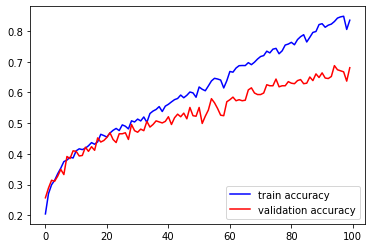

In [ ]:
plt.plot(history2.history['accuracy'],c='b',label='train accuracy')
plt.plot(history2.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_loss, test_acc = model2.evaluate(X_test, y_test, verbose=2)
print('\n Test Acc: ', test_acc)

33/33 - 1s - loss: 1.0454 - accuracy: 0.6762 - 709ms/epoch - 21ms/step

 Test Acc:  0.6761904954910278


In [ ]:
model3 = Sequential()

model3.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(25,1))) #X.shape[1:2]
model3.add(Bidirectional(LSTM(64)))

model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))

model3.add(Dense(y_lstm.shape[1], activation='softmax')) # final output 7 emotions. y_lstm.shape=7000 * 7

## Compiling the model
model3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 25, 128)          33792     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 7)                 231       
                                                                 
Total params: 136,967
Trainable params: 136,967
Non-tr

In [ ]:
## Training the Model
history3= model3.fit(X_train, y_train, epochs=150, batch_size= 256, validation_split=0.1,
                   shuffle=True, callbacks=[mc])

Epoch 1/150
21/21 [==============================] - ETA: 0s - loss: 1.8535 - accuracy: 0.2308
Epoch 1: val_accuracy did not improve from 0.68739
21/21 [==============================] - 18s 427ms/step - loss: 1.8535 - accuracy: 0.2308 - val_loss: 1.7531 - val_accuracy: 0.2975
Epoch 2/150
21/21 [==============================] - ETA: 0s - loss: 1.7364 - accuracy: 0.2962
Epoch 2: val_accuracy did not improve from 0.68739
21/21 [==============================] - 6s 289ms/step - loss: 1.7364 - accuracy: 0.2962 - val_loss: 1.7190 - val_accuracy: 0.2941
Epoch 3/150
21/21 [==============================] - ETA: 0s - loss: 1.6908 - accuracy: 0.3076
Epoch 3: val_accuracy did not improve from 0.68739
21/21 [==============================] - 7s 343ms/step - loss: 1.6908 - accuracy: 0.3076 - val_loss: 1.6992 - val_accuracy: 0.2874
Epoch 4/150
21/21 [==============================] - ETA: 0s - loss: 1.6543 - accuracy: 0.3309
Epoch 4: val_accuracy did not improve from 0.68739
21/21 [===============

21/21 [==============================] - 7s 319ms/step - loss: 1.0677 - accuracy: 0.5782 - val_loss: 1.1021 - val_accuracy: 0.5748
Epoch 31/150
21/21 [==============================] - ETA: 0s - loss: 1.0697 - accuracy: 0.5789
Epoch 31: val_accuracy did not improve from 0.68739
21/21 [==============================] - 7s 317ms/step - loss: 1.0697 - accuracy: 0.5789 - val_loss: 1.1395 - val_accuracy: 0.5496
Epoch 32/150
21/21 [==============================] - ETA: 0s - loss: 1.0516 - accuracy: 0.5914
Epoch 32: val_accuracy did not improve from 0.68739
21/21 [==============================] - 7s 325ms/step - loss: 1.0516 - accuracy: 0.5914 - val_loss: 1.1103 - val_accuracy: 0.5832
Epoch 33/150
21/21 [==============================] - ETA: 0s - loss: 1.0296 - accuracy: 0.5965
Epoch 33: val_accuracy did not improve from 0.68739
21/21 [==============================] - 7s 323ms/step - loss: 1.0296 - accuracy: 0.5965 - val_loss: 1.0716 - val_accuracy: 0.5899
Epoch 34/150
21/21 [============

Epoch 60/150
21/21 [==============================] - ETA: 0s - loss: 0.7061 - accuracy: 0.7283
Epoch 60: val_accuracy did not improve from 0.68739
21/21 [==============================] - 8s 369ms/step - loss: 0.7061 - accuracy: 0.7283 - val_loss: 1.1566 - val_accuracy: 0.5933
Epoch 61/150
21/21 [==============================] - ETA: 0s - loss: 0.7469 - accuracy: 0.7100
Epoch 61: val_accuracy did not improve from 0.68739
21/21 [==============================] - 8s 353ms/step - loss: 0.7469 - accuracy: 0.7100 - val_loss: 0.9718 - val_accuracy: 0.6370
Epoch 62/150
21/21 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.7279
Epoch 62: val_accuracy did not improve from 0.68739
21/21 [==============================] - 7s 328ms/step - loss: 0.6908 - accuracy: 0.7279 - val_loss: 0.9822 - val_accuracy: 0.6454
Epoch 63/150
21/21 [==============================] - ETA: 0s - loss: 0.6655 - accuracy: 0.7421
Epoch 63: val_accuracy did not improve from 0.68739
21/21 [========

Epoch 118/150
21/21 [==============================] - ETA: 0s - loss: 0.2180 - accuracy: 0.9223
Epoch 118: val_accuracy did not improve from 0.72941
21/21 [==============================] - 7s 325ms/step - loss: 0.2180 - accuracy: 0.9223 - val_loss: 1.0155 - val_accuracy: 0.7261
Epoch 119/150
21/21 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.9178
Epoch 119: val_accuracy improved from 0.72941 to 0.73109, saving model to ./model.h5
21/21 [==============================] - 7s 320ms/step - loss: 0.2255 - accuracy: 0.9178 - val_loss: 1.0515 - val_accuracy: 0.7311
Epoch 120/150
21/21 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.9225
Epoch 120: val_accuracy did not improve from 0.73109
21/21 [==============================] - 8s 357ms/step - loss: 0.2175 - accuracy: 0.9225 - val_loss: 1.1003 - val_accuracy: 0.7176
Epoch 121/150
21/21 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9242
Epoch 121: val_accuracy did 

Epoch 147/150
21/21 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9699
Epoch 147: val_accuracy did not improve from 0.74118
21/21 [==============================] - 7s 325ms/step - loss: 0.0958 - accuracy: 0.9699 - val_loss: 1.3544 - val_accuracy: 0.7008
Epoch 148/150
21/21 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9636
Epoch 148: val_accuracy did not improve from 0.74118
21/21 [==============================] - 7s 325ms/step - loss: 0.1064 - accuracy: 0.9636 - val_loss: 1.3105 - val_accuracy: 0.7294
Epoch 149/150
21/21 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9725
Epoch 149: val_accuracy did not improve from 0.74118
21/21 [==============================] - 7s 343ms/step - loss: 0.0899 - accuracy: 0.9725 - val_loss: 1.2966 - val_accuracy: 0.7277
Epoch 150/150
21/21 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9722
Epoch 150: val_accuracy did not improve from 0.74118
21/21 [

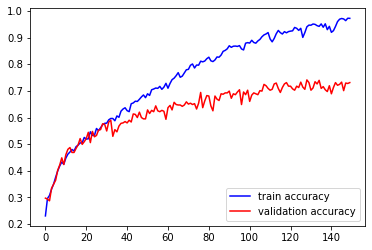

In [ ]:
plt.plot(history3.history['accuracy'],c='b',label='train accuracy')
plt.plot(history3.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_loss, test_acc = model3.evaluate(X_test, y_test, verbose=2)
print('\n Test Acc: ', test_acc)

33/33 - 1s - loss: 1.3514 - accuracy: 0.7429 - 639ms/epoch - 19ms/step

 Test Acc:  0.7428571581840515


In [ ]:
#  train set and test set for LSTM Model 5
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.15, random_state=0) # convert X to array 

In [ ]:
model5 = Sequential()

model5.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(75,1))) #X.shape[1:2]
model5.add(Bidirectional(LSTM(64)))

model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.2))

model5.add(Dense(y_lstm.shape[1], activation='softmax')) # final output 7 emotions. y_lstm.shape=7000 * 7

## Compiling the model
model5.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 75, 128)          33792     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 7)                 455       
                                                                 
Total params: 141,319
Trainable params: 141,319
Non-tr

In [ ]:
## Training the Model
history3= model5.fit(X_train, y_train, epochs=150, batch_size= 256, validation_split=0.1,
                   shuffle=True, callbacks=[mc])

Epoch 1/150
21/21 [==============================] - ETA: 0s - loss: 1.7508 - accuracy: 0.2779
Epoch 1: val_accuracy improved from -inf to 0.33445, saving model to ./model.h5
21/21 [==============================] - 34s 1s/step - loss: 1.7508 - accuracy: 0.2779 - val_loss: 1.6473 - val_accuracy: 0.3345
Epoch 2/150
21/21 [==============================] - ETA: 0s - loss: 1.5725 - accuracy: 0.3576
Epoch 2: val_accuracy improved from 0.33445 to 0.38992, saving model to ./model.h5
21/21 [==============================] - 21s 972ms/step - loss: 1.5725 - accuracy: 0.3576 - val_loss: 1.5607 - val_accuracy: 0.3899
Epoch 3/150
21/21 [==============================] - ETA: 0s - loss: 1.4918 - accuracy: 0.3935
Epoch 3: val_accuracy improved from 0.38992 to 0.40000, saving model to ./model.h5
21/21 [==============================] - 21s 976ms/step - loss: 1.4918 - accuracy: 0.3935 - val_loss: 1.4865 - val_accuracy: 0.4000
Epoch 4/150
21/21 [==============================] - ETA: 0s - loss: 1.4244 

21/21 [==============================] - ETA: 0s - loss: 0.3744 - accuracy: 0.8631
Epoch 56: val_accuracy did not improve from 0.75630
21/21 [==============================] - 20s 953ms/step - loss: 0.3744 - accuracy: 0.8631 - val_loss: 0.7594 - val_accuracy: 0.7361
Epoch 57/150
21/21 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.8697
Epoch 57: val_accuracy did not improve from 0.75630
21/21 [==============================] - 19s 905ms/step - loss: 0.3576 - accuracy: 0.8697 - val_loss: 0.7622 - val_accuracy: 0.7429
Epoch 58/150
21/21 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.8816
Epoch 58: val_accuracy did not improve from 0.75630
21/21 [==============================] - 19s 901ms/step - loss: 0.3358 - accuracy: 0.8816 - val_loss: 0.7443 - val_accuracy: 0.7496
Epoch 59/150
21/21 [==============================] - ETA: 0s - loss: 0.3332 - accuracy: 0.8807
Epoch 59: val_accuracy did not improve from 0.75630
21/21 [==================

21/21 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.9740
Epoch 114: val_accuracy did not improve from 0.79328
21/21 [==============================] - 20s 939ms/step - loss: 0.0837 - accuracy: 0.9740 - val_loss: 0.9469 - val_accuracy: 0.7681
Epoch 115/150
21/21 [==============================] - ETA: 0s - loss: 0.1197 - accuracy: 0.9613
Epoch 115: val_accuracy did not improve from 0.79328
21/21 [==============================] - 19s 906ms/step - loss: 0.1197 - accuracy: 0.9613 - val_loss: 1.0078 - val_accuracy: 0.7731
Epoch 116/150
21/21 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9462
Epoch 116: val_accuracy did not improve from 0.79328
21/21 [==============================] - 20s 936ms/step - loss: 0.1634 - accuracy: 0.9462 - val_loss: 1.0057 - val_accuracy: 0.7630
Epoch 117/150
21/21 [==============================] - ETA: 0s - loss: 0.2001 - accuracy: 0.9298
Epoch 117: val_accuracy did not improve from 0.79328
21/21 [===========

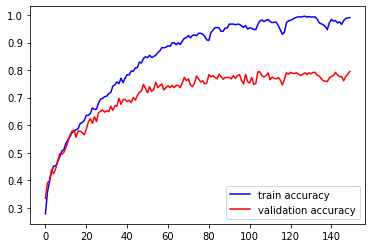

In [ ]:
# Plotting hisotry of MOdel 5
plt.plot(history3.history['accuracy'],c='b',label='train accuracy')
plt.plot(history3.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_loss, test_acc = model5.evaluate(X_test, y_test, verbose=2)
print('\n Test Acc: ', test_acc)

33/33 - 3s - loss: 1.0102 - accuracy: 0.8095 - 3s/epoch - 100ms/step

 Test Acc:  0.8095238208770752


In [ ]:
model6 = Sequential()

model6.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(75,1))) #X.shape[1:2]
model6.add(Bidirectional(LSTM(64)))

model6.add(Dense(64, activation='relu'))
model6.add(Dropout(0.2))

model6.add(Dense(y_lstm.shape[1], activation='softmax')) # final output 7 emotions. y_lstm.shape=7000 * 7

## Compiling the model
model6.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 75, 256)          133120    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 7)                 455       
                                                                 
Total params: 306,183
Trainable params: 306,183
Non-tr

In [ ]:
## Training the Model
history6= model6.fit(X_train, y_train, epochs=200, batch_size= 256, validation_split=0.1,
                   shuffle=True, callbacks=[mc])

Epoch 1/200
21/21 [==============================] - ETA: 0s - loss: 1.7386 - accuracy: 0.3048
Epoch 1: val_accuracy did not improve from 0.79496
21/21 [==============================] - 55s 2s/step - loss: 1.7386 - accuracy: 0.3048 - val_loss: 1.6041 - val_accuracy: 0.3731
Epoch 2/200
21/21 [==============================] - ETA: 0s - loss: 1.5457 - accuracy: 0.3823
Epoch 2: val_accuracy did not improve from 0.79496
21/21 [==============================] - 46s 2s/step - loss: 1.5457 - accuracy: 0.3823 - val_loss: 1.5107 - val_accuracy: 0.4336
Epoch 3/200
21/21 [==============================] - ETA: 0s - loss: 1.4834 - accuracy: 0.4129
Epoch 3: val_accuracy did not improve from 0.79496
21/21 [==============================] - 46s 2s/step - loss: 1.4834 - accuracy: 0.4129 - val_loss: 1.4655 - val_accuracy: 0.4319
Epoch 4/200
21/21 [==============================] - ETA: 0s - loss: 1.4203 - accuracy: 0.4334
Epoch 4: val_accuracy did not improve from 0.79496
21/21 [======================

Epoch 31/200
21/21 [==============================] - ETA: 0s - loss: 0.6344 - accuracy: 0.7651
Epoch 31: val_accuracy did not improve from 0.79496
21/21 [==============================] - 43s 2s/step - loss: 0.6344 - accuracy: 0.7651 - val_loss: 0.8286 - val_accuracy: 0.6874
Epoch 32/200
21/21 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.7707
Epoch 32: val_accuracy did not improve from 0.79496
21/21 [==============================] - 43s 2s/step - loss: 0.6047 - accuracy: 0.7707 - val_loss: 0.7953 - val_accuracy: 0.6958
Epoch 33/200
21/21 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.7744
Epoch 33: val_accuracy did not improve from 0.79496
21/21 [==============================] - 38s 2s/step - loss: 0.6028 - accuracy: 0.7744 - val_loss: 0.8525 - val_accuracy: 0.7025
Epoch 34/200
21/21 [==============================] - ETA: 0s - loss: 0.6161 - accuracy: 0.7653
Epoch 34: val_accuracy did not improve from 0.79496
21/21 [==============

Epoch 61/200
21/21 [==============================] - ETA: 0s - loss: 0.2173 - accuracy: 0.9257
Epoch 61: val_accuracy did not improve from 0.79496
21/21 [==============================] - 38s 2s/step - loss: 0.2173 - accuracy: 0.9257 - val_loss: 0.7865 - val_accuracy: 0.7563
Epoch 62/200
21/21 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9247
Epoch 62: val_accuracy did not improve from 0.79496
21/21 [==============================] - 38s 2s/step - loss: 0.2148 - accuracy: 0.9247 - val_loss: 0.8740 - val_accuracy: 0.7395
Epoch 63/200
21/21 [==============================] - ETA: 0s - loss: 0.2141 - accuracy: 0.9275
Epoch 63: val_accuracy did not improve from 0.79496
21/21 [==============================] - 41s 2s/step - loss: 0.2141 - accuracy: 0.9275 - val_loss: 0.8157 - val_accuracy: 0.7479
Epoch 64/200
21/21 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9311
Epoch 64: val_accuracy did not improve from 0.79496
21/21 [==============

21/21 [==============================] - 39s 2s/step - loss: 0.1460 - accuracy: 0.9582 - val_loss: 0.9547 - val_accuracy: 0.7664
Epoch 91/200
21/21 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9576
Epoch 91: val_accuracy did not improve from 0.80168
21/21 [==============================] - 39s 2s/step - loss: 0.1341 - accuracy: 0.9576 - val_loss: 0.8843 - val_accuracy: 0.7765
Epoch 92/200
21/21 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9703
Epoch 92: val_accuracy did not improve from 0.80168
21/21 [==============================] - 37s 2s/step - loss: 0.0963 - accuracy: 0.9703 - val_loss: 0.8339 - val_accuracy: 0.8017
Epoch 93/200
21/21 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9677
Epoch 93: val_accuracy did not improve from 0.80168
21/21 [==============================] - 40s 2s/step - loss: 0.0928 - accuracy: 0.9677 - val_loss: 1.0282 - val_accuracy: 0.7748
Epoch 94/200
21/21 [====================

Epoch 120/200
21/21 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9838
Epoch 120: val_accuracy did not improve from 0.80672
21/21 [==============================] - 46s 2s/step - loss: 0.0552 - accuracy: 0.9838 - val_loss: 0.9051 - val_accuracy: 0.7966
Epoch 121/200
21/21 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9894
Epoch 121: val_accuracy improved from 0.80672 to 0.81176, saving model to ./model.h5
21/21 [==============================] - 46s 2s/step - loss: 0.0403 - accuracy: 0.9894 - val_loss: 0.9061 - val_accuracy: 0.8118
Epoch 122/200
21/21 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9953
Epoch 122: val_accuracy improved from 0.81176 to 0.81681, saving model to ./model.h5
21/21 [==============================] - 46s 2s/step - loss: 0.0246 - accuracy: 0.9953 - val_loss: 0.8983 - val_accuracy: 0.8168
Epoch 123/200
21/21 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9978
Ep

Epoch 149/200
21/21 [==============================] - ETA: 0s - loss: 0.2199 - accuracy: 0.9333
Epoch 149: val_accuracy did not improve from 0.83025
21/21 [==============================] - 38s 2s/step - loss: 0.2199 - accuracy: 0.9333 - val_loss: 1.1169 - val_accuracy: 0.7429
Epoch 150/200
21/21 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9272
Epoch 150: val_accuracy did not improve from 0.83025
21/21 [==============================] - 38s 2s/step - loss: 0.2256 - accuracy: 0.9272 - val_loss: 1.0471 - val_accuracy: 0.7546
Epoch 151/200
21/21 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9296
Epoch 151: val_accuracy did not improve from 0.83025
21/21 [==============================] - 40s 2s/step - loss: 0.2074 - accuracy: 0.9296 - val_loss: 0.9449 - val_accuracy: 0.7529
Epoch 152/200
21/21 [==============================] - ETA: 0s - loss: 0.1371 - accuracy: 0.9548
Epoch 152: val_accuracy did not improve from 0.83025
21/21 [======

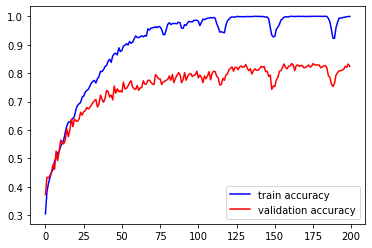

In [ ]:
# Plotting hisotry of MOdel 6
plt.plot(history6.history['accuracy'],c='b',label='train accuracy')
plt.plot(history6.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

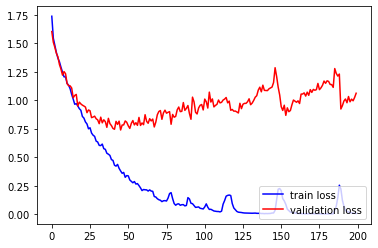

In [ ]:
# Plotting hisotry of MOdel 6
plt.plot(history6.history['loss'],c='b',label='train loss')
plt.plot(history6.history['val_loss'],c='r',label='validation loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_loss, test_acc = model6.evaluate(X_test, y_test, verbose=2)
print('\n Test Acc: ', test_acc)

33/33 - 6s - loss: 0.8534 - accuracy: 0.8257 - 6s/epoch - 188ms/step

 Test Acc:  0.8257142901420593


In [ ]:
from sklearn import metrics
y_pred =   np.argmax(model6.predict(X_test), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       132
           1       0.80      0.86      0.83       147
           2       0.90      0.89      0.89       149
           3       0.77      0.75      0.76       162
           4       0.77      0.83      0.80       149
           5       0.88      0.86      0.87       159
           6       0.81      0.74      0.78       152

    accuracy                           0.83      1050
   macro avg       0.83      0.83      0.83      1050
weighted avg       0.83      0.83      0.83      1050



In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 1.3 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.2/895.2 KB 1.1 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 862.4 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 KB 3.5 MB/s eta 0:00:00
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4


In [ ]:
model6.save('Bengali_speech_emotion_classfier_Bilstm_83.h5')

In [ ]:
model7 = Sequential()

model7.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=(75,1))) #X.shape[1:2]

model7.add(Dense(64, activation='relu'))
model7.add(Dropout(0.2))

model7.add(Dense(y_lstm.shape[1], activation='softmax')) # final output 7 emotions. y_lstm.shape=7000 * 7

## Compiling the model
model7.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model7.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_14 (Bidirecti  (None, 256)              133120    
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 64)                16448     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 7)                 455       
                                                                 
Total params: 150,023
Trainable params: 150,023
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Training the Model
history7= model7.fit(X_train, y_train, epochs=100, batch_size= 512, validation_split=0.15,
                   shuffle=True, callbacks=[mc, es])

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.9386 - accuracy: 0.1962
Epoch 1: val_accuracy did not improve from 0.83361
10/10 [==============================] - 21s 2s/step - loss: 1.9386 - accuracy: 0.1962 - val_loss: 1.8524 - val_accuracy: 0.2508
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 1.7630 - accuracy: 0.2982
Epoch 2: val_accuracy did not improve from 0.83361
10/10 [==============================] - 15s 2s/step - loss: 1.7630 - accuracy: 0.2982 - val_loss: 1.7379 - val_accuracy: 0.3135
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 1.6636 - accuracy: 0.3346
Epoch 3: val_accuracy did not improve from 0.83361
10/10 [==============================] - 17s 2s/step - loss: 1.6636 - accuracy: 0.3346 - val_loss: 1.6392 - val_accuracy: 0.3572
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 1.5746 - accuracy: 0.3822
Epoch 4: val_accuracy did not improve from 0.83361
10/10 [======================

Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 0.9896 - accuracy: 0.6239
Epoch 31: val_accuracy did not improve from 0.83361
10/10 [==============================] - 17s 2s/step - loss: 0.9896 - accuracy: 0.6239 - val_loss: 1.0894 - val_accuracy: 0.5857
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 0.9692 - accuracy: 0.6288
Epoch 32: val_accuracy did not improve from 0.83361
10/10 [==============================] - 17s 2s/step - loss: 0.9692 - accuracy: 0.6288 - val_loss: 1.0773 - val_accuracy: 0.5913
Epoch 33/100
10/10 [==============================] - ETA: 0s - loss: 0.9576 - accuracy: 0.6342
Epoch 33: val_accuracy did not improve from 0.83361
10/10 [==============================] - 17s 2s/step - loss: 0.9576 - accuracy: 0.6342 - val_loss: 1.0724 - val_accuracy: 0.5901
Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 0.9538 - accuracy: 0.6326
Epoch 34: val_accuracy did not improve from 0.83361
10/10 [==============

Epoch 61/100
10/10 [==============================] - ETA: 0s - loss: 0.6249 - accuracy: 0.7748
Epoch 61: val_accuracy did not improve from 0.83361
10/10 [==============================] - 17s 2s/step - loss: 0.6249 - accuracy: 0.7748 - val_loss: 0.9012 - val_accuracy: 0.6641
Epoch 62/100
10/10 [==============================] - ETA: 0s - loss: 0.6266 - accuracy: 0.7722
Epoch 62: val_accuracy did not improve from 0.83361
10/10 [==============================] - 16s 2s/step - loss: 0.6266 - accuracy: 0.7722 - val_loss: 0.8906 - val_accuracy: 0.6976
Epoch 63/100
10/10 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.7793
Epoch 63: val_accuracy did not improve from 0.83361
10/10 [==============================] - 17s 2s/step - loss: 0.6043 - accuracy: 0.7793 - val_loss: 0.8960 - val_accuracy: 0.6954
Epoch 64/100
10/10 [==============================] - ETA: 0s - loss: 0.5798 - accuracy: 0.7858
Epoch 64: val_accuracy did not improve from 0.83361
10/10 [==============

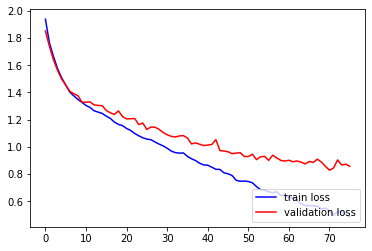

In [ ]:
# Plotting hisotry of MOdel 6
plt.plot(history7.history['loss'],c='b',label='train loss')
plt.plot(history7.history['val_loss'],c='r',label='validation loss')
plt.legend(loc='lower right')
plt.show()

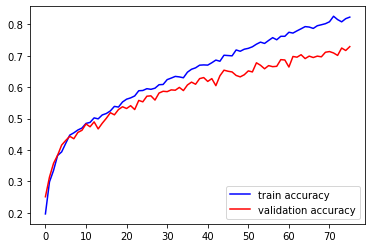

In [ ]:
# Plotting hisotry of MOdel 6
plt.plot(history7.history['accuracy'],c='b',label='train accuracy')
plt.plot(history7.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
def feature_extraction2(filename, mfcc, chroma, mel):
    d, srate = librosa.load(filename, duration=5, offset=0.5)
    if chroma:
        stft = np.abs(librosa.stft(d))
        stft= librosa.amplitude_to_db(stft)
    result = np.array([])
    if mfcc:
        mfccr = np.mean(librosa.feature.mfcc(d, sr=srate, n_mfcc=13).T, axis=0)
        result = np.hstack((result, mfccr))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=srate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel= np.mean(librosa.feature.melspectrogram(d, sr=srate).T, axis=0)
        mel = librosa.power_to_db(mel)
        result = np.hstack((result, mel))
    return result


In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('Bengali_Speech_Emotion_Recognition_Model_SUBESCO.h5')
features = feature_extraction2('RealtimeTest/Angry/angry_nafia.wav', mfcc=True, chroma=True, mel=True)

# convert the 1D array into 2D array
feature=features.reshape(1,-1)
real_test_pred = np.argmax(loaded_model.predict(feature), axis  =  1)
real_test_pred



array([4])

In [ ]:
def feature_extraction3(filename, mfcc, chroma, mel):
    d, srate = librosa.load(filename, duration=5, offset=0.5)
    if chroma:
        stft = np.abs(librosa.stft(d))
        stft= librosa.amplitude_to_db(stft)
    result = np.array([])
    if mfcc:
        mfccr = np.mean(librosa.feature.mfcc(d, sr=srate, n_mfcc=39).T, axis=0)
        result = np.hstack((result, mfccr))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=srate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel= np.mean(librosa.feature.melspectrogram(d, sr=srate).T, axis=0)
        mel = librosa.power_to_db(mel)
        result = np.hstack((result, mel))
    return result
